In [1]:
import igraph as ig
import cairo
import matplotlib.pyplot as plt

from Base import graph_functions as gf
from Base import graph_examples as graph

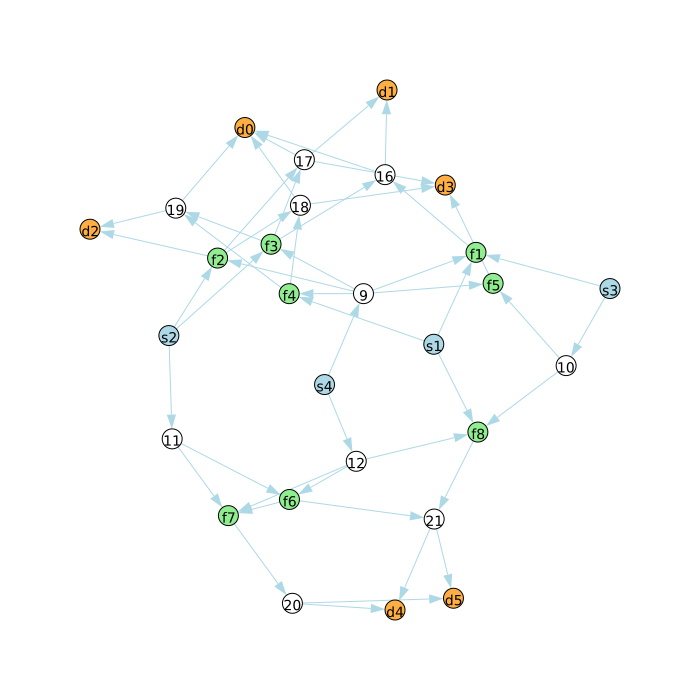

In [2]:
# Creando ejemplo, se puede llamar utilizando import graph_examples as graph
# El ejemplo en particular se denomina lion_example
# Para este caso E = graph.lion_example()

input_edges = [[0,4],[0,7],[0,15]] + [[1,5],[1,11],[1,6]] + [[2,4],[2,10]] + [[3,9],[3,12]]
input_edges += [[4,16]] + [[5,24],[5,17],[5,18]] + [[6,16],[6,17],[6,19]]+ [[7,18],[7,19]]
input_edges += [[8,25]] + [[9,4],[9,5],[9,6],[9,7],[9,8]] + [[10,8],[10,15]]
input_edges += [[11,13],[11,14]] + [[12,13],[12,14],[12,15]]
input_edges += [[13,21],[13,14]] + [[14,20]] + [[15,21]]
input_edges += [[16,22],[16,23]] + [[17,22],[17,23],[17,25]] + [[18,22],[18,25]]
input_edges += [[19,22],[19,24]] 
input_edges +=  [[20,26],[20,27]] + [[21,26],[21,27]]
E = ig.Graph(28,input_edges,directed=True)

## Colores y nombres para vértices
for i in range(0,28):
    E.vs[i]["name"] = str(i)

for i in range(0,28):
    E.vs[i]["color"] = "white"

## Colores y nombres para arcos
for i in range(0,4):
    E.vs[i]["name"] = "s" + str(i+1)
    E.vs[i]["color"] = "light blue"

for i in range(4,9):
    E.vs[i]["name"] = "f" + str(i-3)
    E.vs[i]["color"] = "light green"

for i in range(13,16):
    E.vs[i]["name"] = "f" + str(i-7)
    E.vs[i]["color"] = "light green"

for i in range(22,28):
    E.vs[i]["name"] = "d" + str(i-22)
    E.vs[i]["color"] = "#ffae42" # Yellow orange
    
args = {}
args["layout"] =  E.layout("kk")
args["bbox"] =  (700, 700)
args["vertex_color"] = E.vs["color"]
args["vertex_label"] = E.vs["name"]
args["edge_color"] = "#ADD8E6"
args["edge_width"]= [1]
args["margin"] = 90

ig.plot(E, **args)

---

In [3]:
## AUX FUNCTIONS ## ==========================================================================

def S(G,V,S):
    """
    Data: Graph, Nodes (as a list), Source Set
    Returns: All common sources that reach Nodes in Graph
    """
    S = gf.reachable_dests(G,V,S,False)
    S.sort()
    return S

def c(G,V,D):
    """
    Data: Graph, Nodes (as a list), Dest Set
    Returns: All common destinations that are reachable for Nodes in Graph
    * 18 Jan 2022: As a tuple.
    """
    c = gf.reachable_dests(G,V,D)
    c.sort()
    return tuple(c)

## ==========================================================================================

In [4]:
### Definición de la primera subrutina:

## MODIFIED BFS ## ==========================================================================

def modified_BFS(Graph,Dest,source,Visited_set):
    """
    Data: Graph, Source, N_OLD (Visited nodes in one iteration)
    Returns: New N_OLD, Frontier_array, Tree, Bubble_S

    Summary:
        It visits every node of G_i in Queue order
        For each node it visits, it calculates its neighbors and visits them
        If a neighbor has been visited and its not in the Frontier Set -> It adds it to the set
        If a neighbor has never been visited -> It adds it to the Visited Set (and to the Queue)
        Else -> Then it means we found a generator named Beta_S, and it adds it to the Generator Set (Beta)
    """
    Frontier_array = []
    Tree = []
    Queue = {source}
    BFS_visited_set = {source}
    Bubbles = []

    while Queue:
        u = Queue.pop()
        OUT_nodes = Graph.successors(u)
        for v in OUT_nodes:
            if v in Visited_set and v not in Frontier_array:
                # v was visited by a previous source, then v is Frontier
                # if it is not in the Frontier_array, we add it
                Frontier_array += [v]
                Tree += [(u,v)]
            elif v not in Visited_set and v not in BFS_visited_set:
                # v has never been visited before
                # then we add it to the BFS_visited_set
                # note the BFS_visited_set and Visited_set will join at the end
                BFS_visited_set.add(v)
                Queue.add(v)
                Tree += [(u,v)]
            else:
                # then uv generates a cycle in our Tree
                # B needs to be constructed, but the need information will be stored for now
                Bubbles += [(u,v)]
                ## ##

    return Frontier_array, Tree, Bubbles, BFS_visited_set

In [5]:
### Definición de la segunda subrutina:

## ARC CONSTRUCTION ## ======================================================================

def arc_cons(Graph,Dest,f,g,T2):
    """
    Data: Graph, Destinations, F Node, G Node, Tree2
    Returns: Multigraf Edges, obtained calculating equivalent classes of color

    Summary:
        The arc or edge construction routine consist on finding a nodes, reachable for
        F and G. Upong finding such v node, the color is stored in a set R. 
        The following is to calculate the equivalent classes in R, that consist
        on finding all possible intersections between all elements of R,
        and merging such elements in one. An arc is created for each element remaining
        as its class/color.
    """
    Edges = set()
    Visited_set = {g}
    Queue = {g}
    Used_edges = set()
    Colors_set = set()
    while Queue:
        u = Queue.pop()
        if u not in T2:
            OUT = Graph.successors(u)
            for v in OUT:
                if v not in Visited_set:
                    Used_edges.add((u,v))
                    if v in T2:
                        Colors_set.add(c(Graph,[v],Dest))
                    Visited_set.add(v)
                    Queue.add(v)
    while Colors_set:
        r = Colors_set.pop()
        recheck = True # this is need because new changes introduced in Colors_set
                       # can link new pairs that were already visited
                       # so they'll need to be checked again (rechecked)
        while recheck:
            recheck = False
            Visited = set()
            while Colors_set - Visited:
                p = next(iter(Colors_set-Visited))
                Visited.add(p)
                # r and p are tuples, 
                # hence the union and intersection are more complicated
                if [x for x in p if x in r]: # if intersection of p and r != empty
                    recheck = 1
                    r = tuple([x for x in p] + [x for x in r if x not in p]) # r = r U p
                    Colors_set.remove(p)
        Edges.add((f,g,r))
    return Edges

In [6]:
### Definición de la tercera subrutina:

## EXTENSION SUBROUTINE ## ==================================================================

def Extension_subroutine(Graph,source,Frontier_array, Edges,starting):
    """
    Data: Frontier array, Multigraph Edges, starting node
    Returns: Bubble set

    Summary:
        Builds a tree of represented edges based on the class of each edge.
        Then constructs a bubble set for each represented edge.
    """
    Frontier_set = set(Frontier_array)
    Visited_set = set()
    Generated_edges = set()
    Represented_edges = set()
    Queue = set()

    a = starting
    
    while Frontier_set - Visited_set:
        # is garanteed that those edges which "arrive" to a will be visited?
        Visited_set.add(a)
        S = Edges - Generated_edges # E/E'
        S = {x for x in S if a in x} # S(a)
        # == E(a)/E'

        for e in S:
            # Note that each e edge is composed of a starting a node, destination b node
            # And class color
            a, b, color = e 

            if b not in Visited_set and b not in Queue:
                Queue.add(b) # this is equivalent to d(V') set

            # Generated edges for a and b
            diff = Edges.intersection(Generated_edges)
            a_edges = {x for x in diff if a in x}
            b_edges = {x for x in diff if b in x}

            # The operation is equivalent to L()
            A = set()
            for d in a_edges:
                A = A.union([x for x in d[2]])
            
            B = set()
            for d in b_edges:
                B = B.union([x for x in d[2]])

            # Intersection of classes
            # We are looking for an empty set
            inter = A.intersection(B).intersection({x for x in color})
            
            if not inter:
                Represented_edges.add(e)
            
            Generated_edges.add(e)
        
        
        if Queue:
            a = Queue.pop()
        else:
            if Frontier_set - Visited_set:
                a = next(iter(Frontier_set - Visited_set))

    return Represented_edges

## ==========================================================================================

In [7]:
### Definición de algo algoritmo principal:

## BASE ## ==================================================================================

def bubble_search(Graph, Sources, Dest):
    """
    Data: Graph, Sources and Dest
    Returns: Generator Set (of Bubbles)
    """

    MFS = []
    FS = []
    MES =[]
    TG = []

    Visited_set = set()
    Bubble_set = set()
    Visited_sources = set()

    for s in Sources:
        ## MODIFIED BFS SUBROUTINE
        Frontier_array, Tree, New_bubbles, BFS_visited_set = modified_BFS(Graph,Dest,s,Visited_set)
        Bubble_set.add((s,tuple(Tree),tuple(New_bubbles)))
        Visited_set = Visited_set | BFS_visited_set
        
        # the following will consist in the construction of the multigraf
        Multigraf_edge_set = set()
        for f in Frontier_array:
            # T2 -> reachable for f
            T2 = [x for x in gf.bfs(Graph, f) if x != f]
            for g in Frontier_array:
                if Frontier_array.index(f) < Frontier_array.index(g):
                    # if f and g both reachable by a previously visited source
                    if [x for x in S(Graph,[f,g],Sources) if x in Visited_sources]:
                        color = c(Graph,[f,g],Dest) # color or class or tag
                        # and if they share at least one destination node
                        if color:
                            # we add its corresponding edge to the multigraf
                            Multigraf_edge_set.add((f,g,color))
                    else:
                        ## ARC CONSTRUCTION SUBROUTINE
                        Edges = arc_cons(Graph,Dest,f,g,T2)
                        Multigraf_edge_set = Multigraf_edge_set | Edges
        
        ## Multigraf Construction ##
        Multigraf = ig.Graph()

        ## first source will never have a Frontier, by definition
        Ext = []
        if Frontier_array:
            ## EXTENSION SUBROUTINE
            starting = Frontier_array[0]
            Ext = Extension_subroutine(Graph,s,Frontier_array,Multigraf_edge_set,starting)
            

            ## GRAPH MULTIGRAPH ##
            Multigraf.add_vertices(Frontier_array)
            Multigraf.vs["color"] = ["#86d549" for x in Frontier_array]
            ei = 0
            for edge in Multigraf_edge_set:
            # edge[0] -> [fg], so edge[0][0] is f and edge[0][1] is g
            # edge[1] -> [fg] Class
                Multigraf.add_edge(Multigraf.vs.find(name=edge[0]), Multigraf.vs.find(name=edge[1]))
                Multigraf.es[ei]["label"] = edge[2]
                Multigraf.es[ei]["color"] = "#ADD8E6"
                if edge in Ext:
                    Multigraf.es[ei]["color"] = "#433e85"
                ei+=1
            ## ================ ##

            #Bubble_set.add((s,Multigraf,Ext))

        ## we add the source to the visited sources
        Visited_sources.add(s)

        # this will be returned 
        MFS += [[s,Multigraf,Ext]]
        FS+=[Frontier_array]
        MES += [Multigraf_edge_set]
        

    return MFS, FS, Bubble_set, MES

## ==========================================================================================

## Visualización

### Definiciones de las funciones auxiliares:

In [8]:
# Cargamos la fuente y destino
Source, Dest = gf.get_sources(E)

MFS, F, B, ME= bubble_search(E, Source, Dest)
# Por cada source revisada se dara:
# MFS -> [Fuente, Multigrafo, Arcos representativos]
# ---> Fuente = MFS[i][0] or B[i][0]
#
# F -> [Frontera]
# B -> [Fuente, Árbol recubridor, Arcos que generan ciclos]
# ME -> [Arcos Multigrafo]
# Por cada fuente

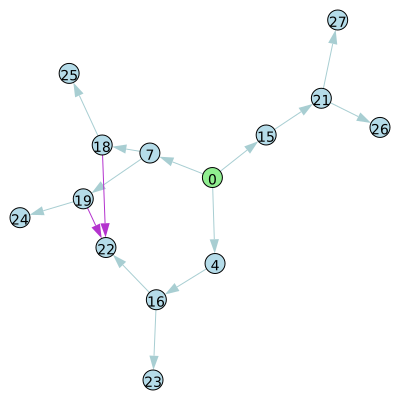

In [9]:
# Visualización
# Using args
# Como ejemplo, tomaremos la primera fuente y su arbol recubridor
Fuente = 0

# Escogemos el arbol recubridor y los arcos que generan ciclos a partir de la fuente
# Cabe recordar que B es una lista de conjuntos, uno por fuente
for bubble in B:
    if bubble[0] == Fuente:
        Arbol = bubble[1]
        Arcos = bubble[2]

# Visualizamos el arbol recubridor
gf.draw_tree(Arbol,Fuente,Arcos)
